<a href="https://colab.research.google.com/github/JSA10/cam_ds_ep_FinSight/blob/topic_model/Topic_modelBOE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install top2vec

In [ ]:
!pip install bertopic

In [ ]:
#Import necessary Libraries
import pandas as pd
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import spacy
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load JPMorgan transcripts from 2023–2025 and preview the first few rows.
df = pd.read_csv("/all_jpm_2023_2025.csv")
df.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
1,qa,NaN,NaN,Steven Chubak,analyst,Wolfe Research LLC,"Hey, good morning.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
2,qa,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, Steve.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...


Filtering pleasantries

In [ ]:
#Filter out pleasantries and small talk to to improve topic modelling and reduce noise.
df_filtered = df[df['is_pleasantry'] == False].copy()
df_filtered.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
5,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
6,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...


Handling missing content

In [ ]:
# Replace missing content with empty strings and remove blank entries.
df_filtered['content'] = df_filtered['content'].fillna('')
df_filtered = df_filtered[df_filtered['content'].str.strip() != '']

In [ ]:
#  Reset index after filtering to ensure clean, sequential row labels.
df_filtered.reset_index(drop=True, inplace=True)

In [ ]:
# Display the number of cleaned transcripts and preview key  columns.
print(f"Cleaned transcript count: {len(df_filtered)}")
df_filtered[['quarter', 'year', 'speaker_name', 'content']].head()

Cleaned transcript count: 1218


,quarter,year,speaker_name,content
0,Q1,2023,Jeremy Barnum,"Thanks, and good morning, everyone. The presen..."
1,Q1,2023,Steven Chubak,"So, Jamie, I was actually hoping to get your p..."
2,Q1,2023,Jamie Dimon,"Well, I think you were already kind of complet..."
3,Q1,2023,Steven Chubak,Got it. And just in terms of appetite for the ...
4,Q1,2023,Jamie Dimon,"Oh, yeah."


Cleaning and Preprocessing  text data using spacy and regular expression

In [ ]:
# Load spaCy NLP pipeline and Counter for token frequency analysis.

import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")
#  Regex-based cleaner to remove numbers and punctuation, and lowercase the text.
def clean_text_regex(text):
    import re

    text = str(text)
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text.lower().strip()
# Lemmatize tokens, remove stopwords and custom financial filler terms for cleaner semantic input.

def preprocess_with_spacy(text, custom_stopwords=None):
    if not isinstance(text, str):
        return []
    custom_stopwords = custom_stopwords or set([
        'billion', 'million', 'trillion', 'earnings', 'quarter', 'year', 'revenue',
        'net', 'income', 'share', 'analyst', 'call', 'firm', 'bank', 'banking',
        'financial', 'market', 'stock', 'investor', 'investing', 'credit', 'report',
        'growth', 'guidance', 'expense', 'per', 'cents', 'p', 'loan', 'deposit',
        'margin', 'rate', 'interest', 'federal', 'reserve','think', 'question', 'thing', 'thank', 'capital', 'bit', 'book', 'year', 'right',
    'kind', 'come', 'know', 'obviously', 'talk', 'want', 'point', 'lot', 'actually', 'mean',
    'yeah', 'no', 'yes', 've', 's', 'like', 'see', 'say', 'good', 'start', 'end', 'page'
    ])
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.lemma_ not in custom_stopwords]


# Apply regex cleaning to transcript content to standardize text before NLP processing.

df_filtered['regex_cleaned'] = df_filtered['content'].astype(str).apply(clean_text_regex)

# Tokenize and lemmatize cleaned text using spaCy, excluding stopwords and domain-specific noise.

df_filtered['spacy_tokens'] = df_filtered['regex_cleaned'].apply(preprocess_with_spacy)

# Flatten all tokens for frequency filtering.
all_tokens = [token for tokens in df_filtered['spacy_tokens'] for token in tokens]
token_counts = Counter(all_tokens)

# Minimum and maximum frequency thresholds to filter out rare and overly common tokens.
min_freq = 2
max_freq = len(df_filtered) * 0.8

# Filter tokens based on frequency.
df_filtered['filtered_tokens'] = df_filtered['spacy_tokens'].apply(
    lambda tokens: [token for token in tokens if min_freq <= token_counts[token] <= max_freq]
)

# Convert filtered token lists back into strings for embedding and clustering.
df_filtered['filtered_string'] = df_filtered['filtered_tokens'].apply(lambda x: ' '.join(x))

# Display summary statistics of token counts per document after filtering.
print("Token count stats:")
print(df_filtered['filtered_tokens'].apply(len).describe())

Token count stats:
count    1218.000000
mean       35.990148
std        73.631519
min         0.000000
25%         7.000000
50%        21.000000
75%        42.000000
max       932.000000
Name: filtered_tokens, dtype: float64


/tmp/ipython-input-2659893397.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=token_df.head(30), x='token', y='count', palette='pink')


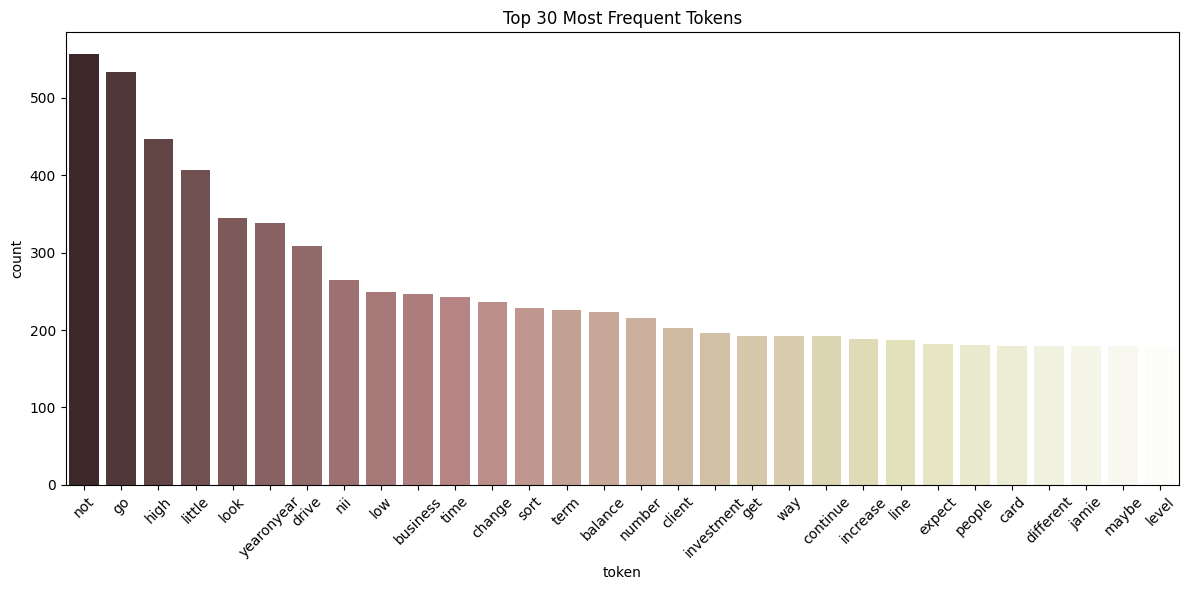

In [ ]:
# Visualize the top 30 most frequent tokens  in the cleaned transcripts.
import matplotlib.pyplot as plt
import seaborn as sns

token_df = pd.DataFrame(token_counts.items(), columns=['token', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=token_df.head(30), x='token', y='count', palette='pink')
plt.xticks(rotation=45)
plt.title("Top 30 Most Frequent Tokens")
plt.tight_layout()
plt.show()


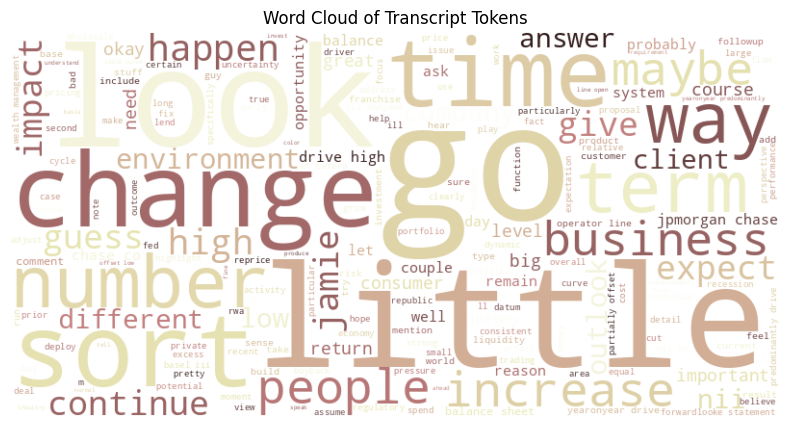

In [ ]:
# Visualize token frequency distribution using a word cloud.
from wordcloud import WordCloud

text_string = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='pink').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Transcript Tokens")
plt.show()


In [ ]:
from collections import Counter

# Flatten all tokens before filtering.
tokens_before = [token for tokens in df_filtered['spacy_tokens'] for token in tokens]
freq_before = Counter(tokens_before)
df_freq_before = pd.DataFrame(freq_before.items(), columns=['token', 'count']).sort_values(by='count', ascending=False).head(30)


In [ ]:
# Analyze top 30 tokens after frequency filtering.
tokens_after = [token for tokens in df_filtered['filtered_tokens'] for token in tokens]
freq_after = Counter(tokens_after)
df_freq_after = pd.DataFrame(freq_after.items(), columns=['token', 'count']).sort_values(by='count', ascending=False).head(30)


In [ ]:
# Compare total token counts before and after frequency filtering to evaluate how much noise was removed.
filtered_tokens_flat = [token for tokens in df_filtered['filtered_tokens'] for token in tokens]
print(f"Total tokens before filtering: {len(all_tokens)}")
print(f"Total tokens after filtering: {len(filtered_tokens_flat)}")

Total tokens before filtering: 44379
Total tokens after filtering: 43836


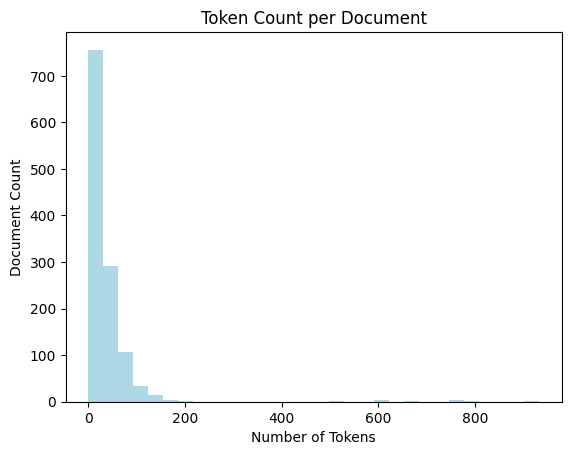

In [ ]:
# Histogram of token count to visualize data distribution.
df_filtered['token_count'] = df_filtered['filtered_tokens'].apply(len)
plt.hist(df_filtered['token_count'], bins=30, color='lightblue')
plt.title("Token Count per Document")
plt.xlabel("Number of Tokens")
plt.ylabel("Document Count")
plt.show()

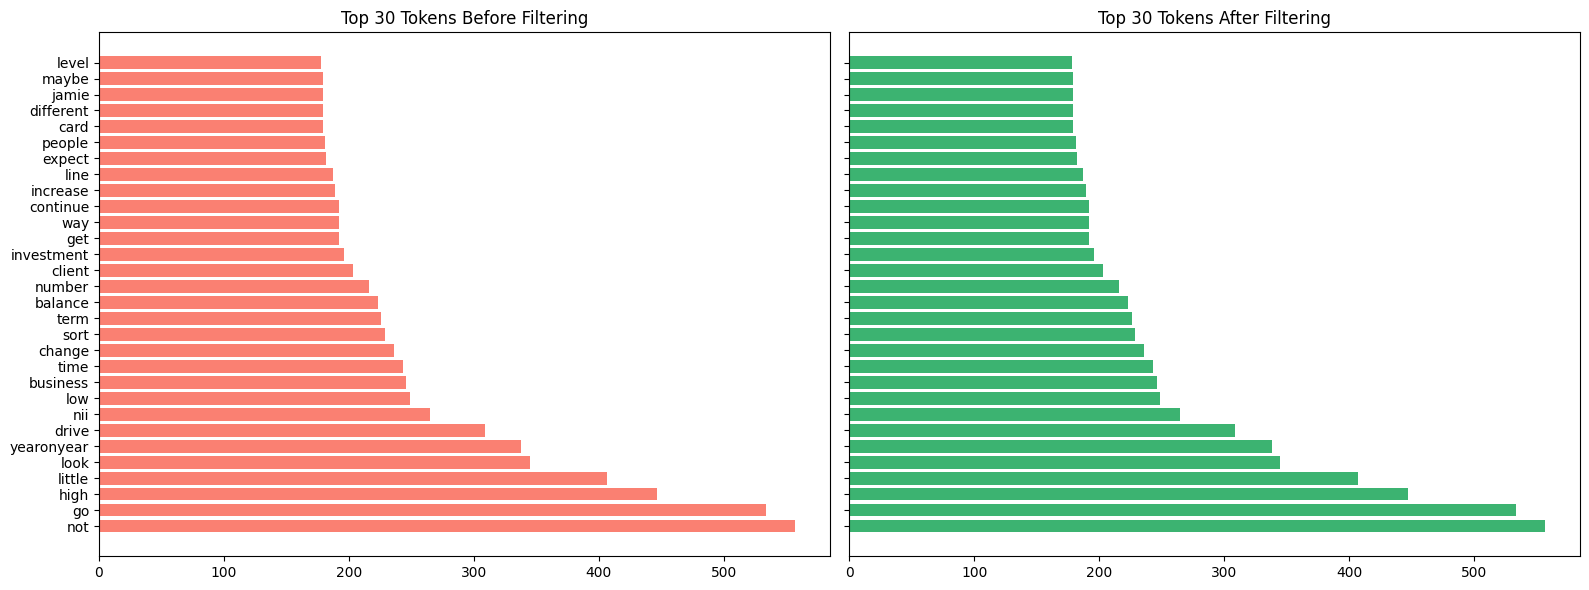

Token count reduced by 1.22% after filtering.


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Before filtering
axes[0].barh(df_freq_before['token'], df_freq_before['count'], color='salmon')
axes[0].set_title('Top 30 Tokens Before Filtering')
axes[0].invert_yaxis()

# After filtering
axes[1].barh(df_freq_after['token'], df_freq_after['count'], color='mediumseagreen')
axes[1].set_title('Top 30 Tokens After Filtering')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
# Token Reduction Summary
reduction = 100 * (1 - len(tokens_after) / len(tokens_before))
print(f"Token count reduced by {reduction:.2f}% after filtering.")

In [ ]:
reduction = 100 * (1 - len(tokens_after) / len(tokens_before))
print(f"Token count reduced by {reduction:.2f}% after filtering.")


Token count reduced by 1.22% after filtering.


Bert topic




In [ ]:
#  # Import BERTopic, SentenceTransformer, and HDBSCAN for topic modeling and clustering.

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

# Load embedding model to generate semantic representations of transcript text.
embedding_model = SentenceTransformer("all-mpnet-base-v2")

# clustering to capture niche topics.
custom_cluster = HDBSCAN(min_cluster_size=2, min_samples=1)

# Extract cleaned and filtered transcript strings for topic modeling input.
texts = df_filtered['filtered_string'].tolist()

#  Initialize and fit BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=custom_cluster)
topics, probs = topic_model.fit_transform(texts)

#  Add topic results to  dataframe.
df_filtered['topic'] = topics
df_filtered['topic_prob'] = probs




/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 Topic Exploration

In [ ]:
# Preview topic modeling output to assess clustering quality and keyword relevance.
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,106,-1_overearne_path_direct_definitely,"[overearne, path, direct, definitely, headwind...",[sure matt guess way couple return tend season...
1,0,10,0_yearonyear_drive_largely_inflow,"[yearonyear, drive, largely, inflow, include, ...",[morning presentation available website refer ...
2,1,8,1_najarian_ubs_erika_proceed,"[najarian, ubs, erika, proceed, line, operator...","[get operator line erika najarian ubs proceed,..."
3,2,8,2_unemployment_central_probabilityweight_adverse,"[unemployment, central, probabilityweight, adv...",[m sure jamie view view caution jump conclusio...
4,3,8,3_agreement_country_american_administration,"[agreement, country, american, administration,...",[betsy different okay different global economy...


In [ ]:
# Visualize the top 10 most frequent topics using a bar chart.
topic_model.visualize_barchart(top_n_topics=10)


In [ ]:
# View representative keywords for Topic 1.
topic_model.get_topic(1)

[('najarian', 0.2942880420529612),
 ('ubs', 0.2942880420529612),
 ('erika', 0.17304010842261552),
 ('proceed', 0.09293899723410066),
 ('line', 0.0909052138917778),
 ('operator', 0.07809882371955515),
 ('steve', 0.07250374486073691),
 ('open', 0.03978179537417714),
 ('poonawala', 0.03828888059907609),
 ('ebrahim', 0.03367932449628398)]

In [ ]:
# View representative keywords for Topic 2.
topic_model.get_topic(2)

[('unemployment', 0.040909517846756935),
 ('central', 0.03737064048473928),
 ('probabilityweight', 0.0346300149296835),
 ('adverse', 0.0346300149296835),
 ('weightedaverage', 0.03179799911510858),
 ('echo', 0.028875141548865012),
 ('skew', 0.027047266641259112),
 ('case', 0.026259643978240422),
 ('tightening', 0.02432434804832292),
 ('weight', 0.023257385648447506)]

In [ ]:
# View representative transcripts for Topic 1 to validate clustering and interpret theme.
topic_model.get_representative_docs(1)

['get operator line erika najarian ubs proceed',
 'operator line erika najarian ubs proceed',
 'operator line erika najarian ubs proceed']

In [ ]:
from sentence_transformers import SentenceTransformer

# Load FinBERT embeddings
embedding_model = SentenceTransformer("ProsusAI/finbert")

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from bertopic import BERTopic
from hdbscan import HDBSCAN

# clustering for niche topics.
custom_cluster = HDBSCAN(min_cluster_size=2, min_samples=1)

# Initialize BERTopic with FinBERT embeddings and custom clustering, then fit to cleaned transcript text.
finbert_model = BERTopic(embedding_model=embedding_model, hdbscan_model=custom_cluster)
texts = df_filtered['filtered_string'].tolist()
finbert_topics, finbert_probs = finbert_model.fit_transform(texts)

# Save FinBERT-based topic assignments and probabilities to the DataFrame for analysis.
df_filtered['topic_finbert'] = finbert_topics
df_filtered['topic_finbert_prob'] = finbert_probs




In [ ]:
# Visualize the top 10 FinBERT-based topics to assess their frequency key themes in the dataset.
finbert_model.visualize_barchart(top_n_topics=10)


In [ ]:
#  Import necessary libraries.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize cleaned text and fit LDA model to extract 10  topics.
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df_filtered['filtered_string'])

# Fit Lda model to extract 10  topics from the vectorized transcript data.
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(X)

LatentDirichletAllocation(random_state=42)

In [ ]:
# Define function to print the top keywords for each LDA topic.
def display_topics(model, feature_names, no_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}: ", [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

display_topics(lda_model, vectorizer.get_feature_names_out())

Topic 0:  ['return', 'look', 'change', 'different', 'client', 'guess', 'way', 'business', 'cycle', 'deploy']
Topic 1:  ['little', 'sort', 'term', 'expect', 'outlook', 'level', 'look', 'continue', 'feel', 'environment']
Topic 2:  ['people', 'look', 'time', 'number', 'little', 'consumer', 'comment', 'jeremy', 'term', 'run']
Topic 3:  ['high', 'jamie', 'number', 'curve', 'little', 'change', 'low', 'cut', 'proposal', 'consumer']
Topic 4:  ['jpmorgan', 'chase', 'statement', 'forwardlooke', 'cos', 'risk', 'happen', 'security', 'look', 'time']
Topic 5:  ['little', 'sort', 'environment', 'term', 'number', 'look', 'business', 'balance', 'maybe', 'sense']
Topic 6:  ['yearonyear', 'drive', 'high', 'nii', 'card', 'low', 'continue', 'offset', 'balance', 'include']
Topic 7:  ['line', 'operator', 'proceed', 'open', 'jeremy', 'okay', 'business', 'ahead', 'helpful', 'liquidity']
Topic 8:  ['time', 'look', 'way', 'need', 'important', 'company', 'little', 'new', 'guess', 'stuff']
Topic 9:  ['look', 'morn

In [ ]:
from top2vec import Top2Vec
# Fit Top2Vec to identify topics based on semantic similarity without prior preprocessing.
model_top2vec = Top2Vec(df_filtered['filtered_string'].tolist(), embedding_model='universal-sentence-encoder')

2025-09-15 21:56:16,111 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2025-09-15 21:56:16,333 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2025-09-15 21:56:43,769 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-09-15 21:56:45,008 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-09-15 21:56:48,330 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-09-15 21:56:48,374 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
# Display representative terms for each Top2Vec topic.
topic_words, word_scores, topic_nums = model_top2vec.get_topics()
for i in range(len(topic_words)):
    print(f"Topic {i}: {topic_words[i][:10]}")

Topic 0: ['volatility' 'recession' 'jpmorgan' 'liquidity' 'uncertainty' 'economy'
 'low' 'chase' 'equity' 'risk']
Topic 1: ['operator' 'chase' 'line' 'jeremy' 'continue' 'jpmorgan' 'uncertainty'
 'open' 'jamie' 'outlook']
Topic 2: ['okay' 'great' 'hear' 'well' 'sure' 'pretty' 'way' 'help' 'hi' 'bad']
Topic 3: ['get' 'take' 'go' 'spend' 'give' 'try' 'make' 'pay' 'fix' 'use']
Topic 4: ['jeremy' 'hear' 'morning' 'chase' 'look' 'consumer' 'jamie' 'lending'
 'big' 'hi']
Topic 5: ['ll' 'not' 'way' 'well' 'second' 'guess' 'et' 'ill' 'answer' 'happen']


1. Extract Top Keywords from Each Model

BERTopic

In [ ]:
# Create a dictionary mapping each  bert topic ID to its top 10 keywords for quick reference.
bert_topics = topic_model.get_topics()
bert_summary = {i: [word for word, _ in bert_topics[i][:10]] for i in bert_topics.keys()}

Finbert

In [ ]:
# Create a dictionary mapping each  finbert topic ID to its top 10 keywords for quick reference.
finbert_topics = finbert_model.get_topics()
finbert_summary = {i: [word for word, _ in finbert_topics[i][:10]] for i in finbert_topics if i != -1}

LDA

In [ ]:
# Extract top 10 keywords for each of the first 10 LDA topics.
lda_keywords = []
for topic in lda_model.components_[:10]:
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    lda_keywords.append(top_words)


Top2Vec

In [ ]:
# Extract top 10 keywords for each of the first 10 top2vec topics.
top2vec_keywords = []
topic_words, _, _ = model_top2vec.get_topics()
for i in range(len(topic_words)):
    top2vec_keywords.append(topic_words[i][:10])

Comparison Table

In [ ]:
# Number of topics discovered by each model
model_scores = {
    'BERTopic': len(bert_summary),
    'FinBERT': len(finbert_summary),
    'LDA': len(lda_keywords),
    'Top2Vec': len(top2vec_keywords)
}
model_scores

{'BERTopic': 378, 'FinBERT': 383, 'LDA': 10, 'Top2Vec': 6}

In [ ]:
# Create a DataFrame comparing top 10 topics across BERTopic, FinBERT, LDA, and Top2Vec models.

top_n = 10
comparison_rows = []
for i in range(top_n):
    row = {
        'Topic': f'Topic {i}',
        'BERTopic': bert_summary.get(i, []),
        'FinBERT': finbert_summary.get(i, []),
        'LDA': lda_keywords[i] if i < len(lda_keywords) else [],
        'Top2Vec': top2vec_keywords[i] if i < len(top2vec_keywords) else []
    }
    comparison_rows.append(row)

top_topics_df = pd.DataFrame(comparison_rows)

In [ ]:
# View the dataframe
top_topics_df

,Topic,BERTopic,FinBERT,LDA,Top2Vec
0,Topic 0,"[yearonyear, drive, largely, inflow, include, ...","[seriously, get, true, not, , , , , , ]","[return, look, change, different, client, gues...","[volatility, recession, jpmorgan, liquidity, u..."
1,Topic 1,"[najarian, ubs, erika, proceed, line, operator...","[schorr, evercore, isi, glenn, open, operator,...","[little, sort, term, expect, outlook, level, l...","[operator, chase, line, jeremy, continue, jpmo..."
2,Topic 2,"[unemployment, central, probabilityweight, adv...","[plumbing, volatility, volume, struggle, ingre...","[people, look, time, number, little, consumer,...","[okay, great, hear, well, sure, pretty, way, h..."
3,Topic 3,"[agreement, country, american, administration,...","[bog, announcement, suggestion, barely, backlo...","[high, jamie, number, curve, little, change, l...","[get, take, go, spend, give, try, make, pay, f..."
4,Topic 4,"[seek, discretionary, rotation, nice, nondiscr...","[excellent, appreciate, great, okay, answer, j...","[jpmorgan, chase, statement, forwardlooke, cos...","[jeremy, hear, morning, chase, look, consumer,..."
5,Topic 5,"[wish, answer, , , , , , , , ]","[tail, ci, compute, fat, prominently, quartero...","[little, sort, environment, term, number, look...","[ll, not, way, well, second, guess, et, ill, a..."
6,Topic 6,"[steepness, curve, premium, yield, invert, nim...","[separately, avenue, overarch, demandsupply, s...","[yearonyear, drive, high, nii, card, low, cont...",[]
7,Topic 7,"[wells, fargo, mayo, mike, efficiently, procee...","[institution, uninsured, plenty, sea, facto, s...","[line, operator, proceed, open, jeremy, okay, ...",[]
8,Topic 8,"[forwardlooke, cos, statement, chase, commissi...","[complex, harm, expose, natural, advocacy, und...","[time, look, way, need, important, company, li...",[]
9,Topic 9,"[importance, measure, adversarial, panoply, su...","[bleed, unemployment, tighten, vulnerability, ...","[look, morning, maybe, little, jeremy, guess, ...",[]


In [ ]:
# Def a function cosine similarity between two keyword lists to measure overlap between topic models.
def cosine_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2)) if list1 and list2 else 0

In [ ]:
# Match semantically similar topics across FinBERT and BertMPNet by comparing top keywords.
matches = []
for i, finbert_keywords in finbert_summary.items():
    for j, mpnet_keywords in bert_summary.items():
        score = cosine_similarity(finbert_keywords, mpnet_keywords)
        if score > 0.5:  # threshold for semantic similarity
            matches.append((i, j, score))

In [ ]:
# Display semantically aligned topics across models based on keyword overlap.
for match in matches:
    print(f"FinBERT Topic {match[0]} ≈ Bert Topic {match[1]} | Similarity: {match[2]:.2f}")

FinBERT Topic 1 ≈ Bert Topic 230 | Similarity: 0.82
FinBERT Topic 1 ≈ Bert Topic 302 | Similarity: 0.64
FinBERT Topic 1 ≈ Bert Topic 316 | Similarity: 0.55
FinBERT Topic 4 ≈ Bert Topic 157 | Similarity: 0.57
FinBERT Topic 14 ≈ Bert Topic 8 | Similarity: 1.00
FinBERT Topic 14 ≈ Bert Topic 23 | Similarity: 0.82
FinBERT Topic 14 ≈ Bert Topic 136 | Similarity: 0.54
FinBERT Topic 18 ≈ Bert Topic 82 | Similarity: 0.67
FinBERT Topic 18 ≈ Bert Topic 211 | Similarity: 0.54
FinBERT Topic 19 ≈ Bert Topic 31 | Similarity: 0.54
FinBERT Topic 20 ≈ Bert Topic 327 | Similarity: 0.67
FinBERT Topic 22 ≈ Bert Topic 330 | Similarity: 0.60
FinBERT Topic 23 ≈ Bert Topic 135 | Similarity: 1.00
FinBERT Topic 26 ≈ Bert Topic 159 | Similarity: 0.60
FinBERT Topic 27 ≈ Bert Topic 324 | Similarity: 0.54
FinBERT Topic 31 ≈ Bert Topic 247 | Similarity: 0.67
FinBERT Topic 34 ≈ Bert Topic 14 | Similarity: 0.54
FinBERT Topic 36 ≈ Bert Topic 16 | Similarity: 0.54
FinBERT Topic 37 ≈ Bert Topic 121 | Similarity: 0.67
FinB

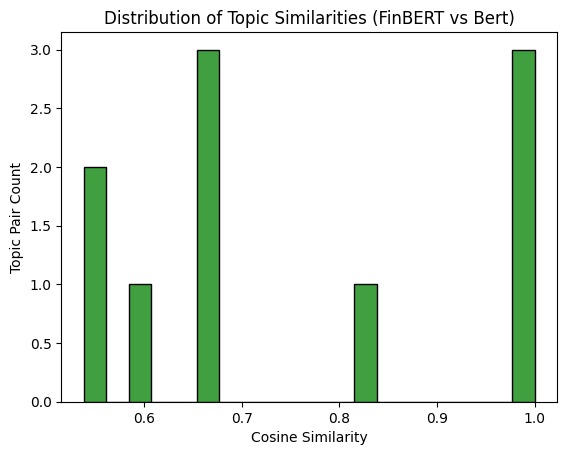

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Plot histogram of cosine similarity scores to assess overlap between FinBERT and BertMPNet topics.

similarities = [match[2] for match in matches]
sns.histplot(similarities, bins=20, color='green')
plt.title("Distribution of Topic Similarities (FinBERT vs Bert)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Topic Pair Count")
plt.show()

###Most topics are exactly the same between the two models suggest by Cosine similarity score of 1, which likely means they’re picking up on common or repeated phrases. But there are also some topics that only partly match, which suggests that FinBERT is better at spotting financial-specific language that BERT sees more generally. #

In [ ]:
matched_ids = [match[0] for match in matches if match[2] >= 0.82]
trend_df = df_filtered[df_filtered['topic_finbert'].isin(matched_ids)]
trend_summary = trend_df.groupby(['year', 'quarter', 'topic_finbert']).size().reset_index(name='count')
trend_summary


,year,quarter,topic_finbert,count
0,2023,Q1,48,1
1,2023,Q1,94,1
2,2023,Q1,120,1
3,2023,Q1,152,2
4,2023,Q1,156,1
...,...,...,...,...
136,2025,Q2,357,2
137,2025,Q2,358,2
138,2025,Q2,367,2
139,2025,Q2,373,2


###HSBC Data


# New section

In [ ]:
Hsbc_df=pd.read_csv('/all_hsbc_earnings_data.csv')
Hsbc_df.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
1,presentation,NaN,NaN,Georges Elhedery,Group Chief Executive,HSBC,"Thank you, Noel, and a warm welcome to all of ...",2023,Q1,True,230502-1q-2023-hsbc-presentation-to-investors-...
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
3,qa,NaN,1.0,Georges Elhedery,management,HSBC,"Thank you, Joe . So first, we are hoping to ac...",2023,Q1,True,230502-1q-2023-hsbc-presentation-to-investors-...
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...


In [ ]:
Hsbc_df= Hsbc_df[Hsbc_df['is_pleasantry'] == False].copy()
Hsbc_df.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
6,qa,NaN,2.0,Noel Quinn,management,HSBC,Just one additional comment from me . You’ll n...,2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
8,qa,NaN,1.0,Noel Quinn,management,HSBC,"Thanks, Manus. Just on the asset quality of S...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...


Handling missing content

In [ ]:
Hsbc_df['content'] = Hsbc_df['content'].fillna('')
Hsbc_df = Hsbc_df[Hsbc_df['content'].str.strip() != '']

In [ ]:
Hsbc_df.reset_index(drop=True, inplace=True)

In [ ]:
#Preview Clean Data
print(f"Cleaned transcript count: {len(Hsbc_df)}")
Hsbc_df[['quarter', 'year', 'speaker_name', 'content']].head()

Cleaned transcript count: 376


,quarter,year,speaker_name,content
0,Q1,2023,Noel Quinn,"Thanks, Richard, and good morning in London, g..."
1,Q1,2023,Georges Elhedery,"Thank you, Noel, and a warm welcome to all of ..."
2,Q1,2023,Joseph Dickerson,"Good morning, gentlemen . Congrats on a good s..."
3,Q1,2023,Georges Elhedery,"Thank you, Joe . So first, we are hoping to ac..."
4,Q1,2023,Raul Sinha,"Good morning, gents . Thanks very much for tak..."


Cleaning and Preprocessing  text data using spacy and regular expression

In [ ]:
# Apply regex cleaning - ensure column is string type first
Hsbc_df['regex_cleaned'] = Hsbc_df['content'].astype(str).apply(clean_text_regex)

# Apply spaCy preprocessing
Hsbc_df['spacy_tokens'] = Hsbc_df['regex_cleaned'].apply(preprocess_with_spacy)

# Flatten all tokens for frequency filtering
all_tokens = [token for tokens in Hsbc_df['spacy_tokens'] for token in tokens]
token_counts = Counter(all_tokens)

# Set frequency thresholds
min_freq = 2
max_freq = len(Hsbc_df) * 0.8

# Filter tokens based on frequency
Hsbc_df['filtered_tokens'] = Hsbc_df['spacy_tokens'].apply(
    lambda tokens: [token for token in tokens if min_freq <= token_counts[token] <= max_freq]
)

# Rejoin tokens into strings for BERTopic input
Hsbc_df['filtered_string'] = Hsbc_df['filtered_tokens'].apply(lambda x: ' '.join(x))

# Optional: inspect token distribution
print("Token count stats:")
print(Hsbc_df['filtered_tokens'].apply(len).describe())

Token count stats:
count    376.000000
mean      78.598404
std      105.618084
min        0.000000
25%       26.000000
50%       53.000000
75%       87.500000
max      852.000000
Name: filtered_tokens, dtype: float64


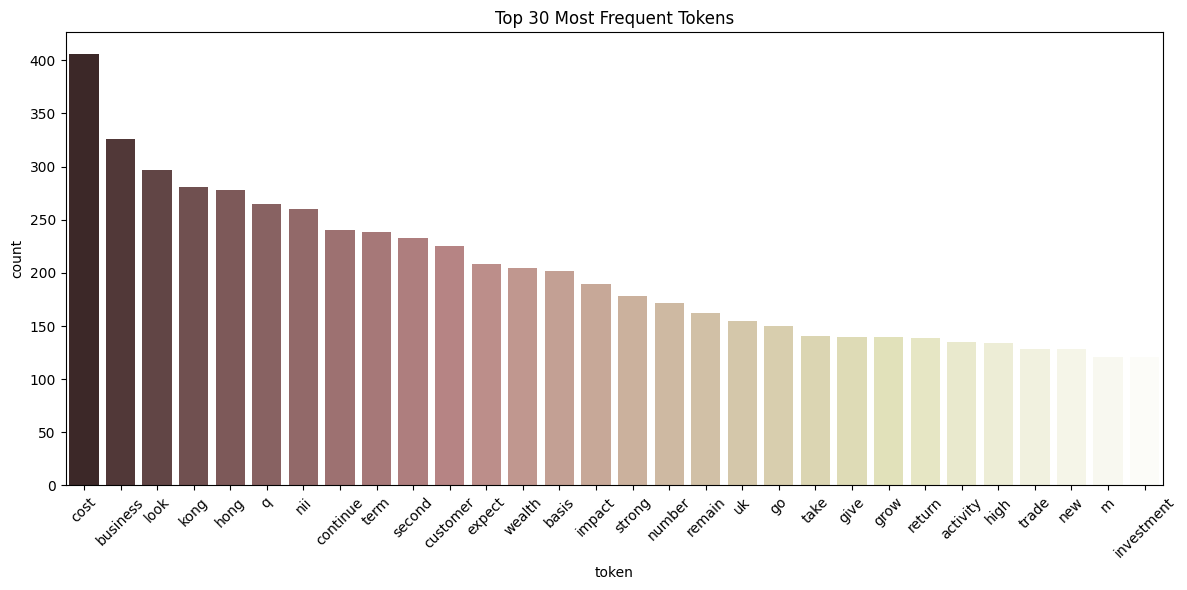

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

token_df = pd.DataFrame(token_counts.items(), columns=['token', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=token_df.head(30), x='token', y='count', palette='pink')
plt.xticks(rotation=45)
plt.title("Top 30 Most Frequent Tokens")
plt.tight_layout()
plt.show()


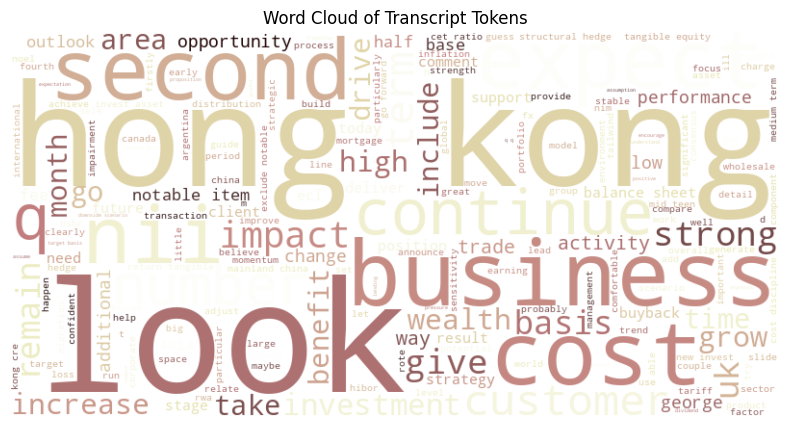

In [ ]:
from wordcloud import WordCloud

text_string = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='pink').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Transcript Tokens")
plt.show()


In [ ]:
from collections import Counter

# Flatten all tokens before filtering
tokens_before = [token for tokens in Hsbc_df['spacy_tokens'] for token in tokens]
freq_before = Counter(tokens_before)
df_freq_before = pd.DataFrame(freq_before.items(), columns=['token', 'count']).sort_values(by='count', ascending=False).head(30)


In [ ]:
tokens_after = [token for tokens in Hsbc_df['filtered_tokens'] for token in tokens]
freq_after = Counter(tokens_after)
df_freq_after = pd.DataFrame(freq_after.items(), columns=['token', 'count']).sort_values(by='count', ascending=False).head(30)


In [ ]:
filtered_tokens_flat = [token for tokens in Hsbc_df['filtered_tokens'] for token in tokens]
print(f"Total Hsbc tokens before filtering: {len(all_tokens)}")
print(f"Total Hsbc tokens after filtering: {len(filtered_tokens_flat)}")

Total Hsbc tokens before filtering: 31648
Total Hsbc tokens after filtering: 29553


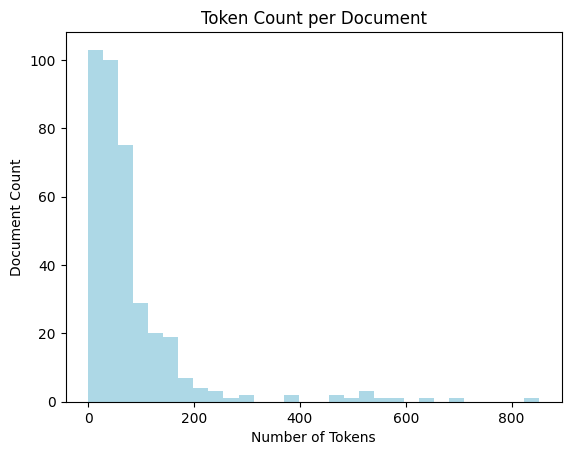

In [ ]:
Hsbc_df['token_count'] = Hsbc_df['filtered_tokens'].apply(len)
plt.hist(Hsbc_df['token_count'], bins=30, color='lightblue')
plt.title("Token Count per Document")
plt.xlabel("Number of Tokens")
plt.ylabel("Document Count")
plt.show()

Bert Topic

In [ ]:
#  # Import BERTopic, SentenceTransformer, and HDBSCAN for topic modeling and clustering.

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

# Load embedding model to generate semantic representations of transcript text.
embedding_model = SentenceTransformer("all-mpnet-base-v2")

# clustering to capture niche topics.
custom_cluster = HDBSCAN(min_cluster_size=2, min_samples=1)

# Extract cleaned and filtered transcript strings for topic modeling input.
Hsbc_text = Hsbc_df['filtered_string'].tolist()

#  Initialize and fit BERTopic model
Hsbc_model = BERTopic(embedding_model=embedding_model, hdbscan_model=custom_cluster)
topics, probs = Hsbc_model.fit_transform(Hsbc_text)

#  Add topic results to  dataframe.
Hsbc_df['topic'] = topics
Hsbc_df['topic_prob'] = probs

In [ ]:
Hsbc_model.visualize_heatmap()

In [ ]:
Hsbc_model.visualize_barchart(top_n_topics=10)

In [ ]:
Hsbc_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,41,-1_look_trade_nii_client,"[look, trade, nii, client, impact, fourth, tar...",[george join fullyear focus discipline way pri...
1,0,15,0_morning_big_noel_wonder,"[morning, big, noel, wonder, street, buyback, ...",[morning l morning george need non perform q a...
2,1,10,1_sankoff_neil_coomb_let,"[sankoff, neil, coomb, let, kunpeng, jeremy, r...","[neil sankoff let andy coomb, neil sankoff let..."
3,2,7,2_sensitivity_structural_hedge_reduction,"[sensitivity, structural, hedge, reduction, up...",[sensitivity downside basis scenario reduce ha...
4,3,6,3_midteen_rote_notable_oneoff,"[midteen, rote, notable, oneoff, understand, a...",[midteen rote target basis ex notable item lin...
5,4,6,4_pam_address_ask_ben,"[pam, address, ask, ben, andrew, remember, go,...",[ben go ask pam address ben remember cet ratio...
6,5,6,5_collateralisation_lending_rwa_portfolio,"[collateralisation, lending, rwa, portfolio, d...",[risk basis encapsulate currently foresee bala...
7,6,6,6_accrue_accrual_acquire_target,"[accrue, accrual, acquire, target, cta, basis,...",[andrew constant currency basis q q adjust not...
8,7,6,7_group_shareholder_hsbc_return,"[group, shareholder, hsbc, return, deliver, ta...",[m jon bingham group controller act interim gr...
9,8,5,8_funding_trading_baseline_arithmetic,"[funding, trading, baseline, arithmetic, nii, ...",[cut nii guide n probably sense reasonable con...


In [ ]:
Hsbc_model.get_topic(1)

[('sankoff', 0.5842134729518867),
 ('neil', 0.5050942731052004),
 ('coomb', 0.19177839718516682),
 ('let', 0.1653332307421793),
 ('kunpeng', 0.14338073222840736),
 ('jeremy', 0.1338136163862251),
 ('rew', 0.09588919859258341),
 ('coombs', 0.09588919859258341),
 ('dickerson', 0.09588919859258341),
 ('barclay', 0.09588919859258341)]

In [ ]:
Hsbc_model.get_topic(2)

[('sensitivity', 0.10258912605117604),
 ('structural', 0.055923371053029275),
 ('hedge', 0.055591028883039996),
 ('reduction', 0.04744493872050566),
 ('uplift', 0.04475078318490151),
 ('pass', 0.0391942791354148),
 ('reduce', 0.03360936326852004),
 ('nii', 0.032168330315662956),
 ('assumption', 0.03033281021679467),
 ('manus', 0.029433681112997635)]

In [ ]:
# Prepare text data
embedding_model = SentenceTransformer("ProsusAI/finbert")
Hsbc_text = Hsbc_df['filtered_string'].tolist()

#  Initialize and fit BERTopic model
Hsbc_Fin_model = BERTopic(embedding_model=embedding_model, hdbscan_model=custom_cluster)
topics, probs = Hsbc_Fin_model.fit_transform(Hsbc_text)

#  Add topic results to  dataframe.
Hsbc_df['topic_finbert'] = topics
Hsbc_df['topic_finbert_prob'] = probs




 Topic Exploration

In [ ]:
Hsbc_Fin_model.visualize_barchart(top_n_topics=10)

In [ ]:
Hsbc_Fin_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,55,-1_sensitivity_valuation_term_give,"[sensitivity, valuation, term, give, impact, n...",[wealth way essentially f ee slide wealth part...
1,0,11,0_sankoff_neil_coomb_dickerson,"[sankoff, neil, coomb, dickerson, let, noble, ...","[neil sankoff let andy coomb, neil sankoff let..."
2,1,8,1_ill_ask_deal_okay,"[ill, ask, deal, okay, teen, mid, cover, barcl...",[morning everybody d echo aman comment noel pr...
3,2,7,2_competitive_franchise_profitability_wealth,"[competitive, franchise, profitability, wealth...",[rob close strong performance provide foundati...
4,3,6,3_trade_east_asia_ringfencing,"[trade, east, asia, ringfencing, differentiati...",[jeremy second asian strategy international st...
5,4,6,4_hold_roe_lack_tell,"[hold, roe, lack, tell, yoy, smoothing, bottom...",[take george pam morning nii couple q q nii ho...
6,5,5,5_mortgage_fall_link_ratesensitive,"[mortgage, fall, link, ratesensitive, kong, co...",[non look breakdown non wealth ll transaction ...
7,6,5,6_street_consensus_great_morning,"[street, consensus, great, morning, conservati...",[morning noel morning george morning richard f...
8,7,5,7_tokenise_responsibility_happy_bocom,"[tokenise, responsibility, happy, bocom, porti...",[ed issuance subscribe government government r...
9,8,5,8_motivation_lcr_fx_bounce,"[motivation, lcr, fx, bounce, hbap, somewhat, ...",[hi take ask nii couple firstly note nim flat ...


In [ ]:
Hsbc_topics = Hsbc_model.get_topics()
Hsbc_bert_summary = {i: [word for word, _ in Hsbc_topics[i][:10]] for i in Hsbc_topics if i != -1}

In [ ]:
Hsbc_Fin_topics = Hsbc_Fin_model.get_topics()
Hsbc_Fin_summary = {i: [word for word, _ in Hsbc_Fin_topics[i][:10]] for i in Hsbc_Fin_topics if i != -1}

In [ ]:
# Def a function cosine similarity between two keyword lists to measure overlap between topic models.
def cosine_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2)) if list1 and list2 else 0

In [ ]:
# Match semantically similar topics across FinBERT and BertMPNet by comparing top keywords.
matches = []
for i, Hsbc_keywords in Hsbc_bert_summary.items():
    for j, Hsbc_Fin_keywords in Hsbc_Fin_summary.items():
        score = cosine_similarity(Hsbc_keywords, Hsbc_Fin_keywords)
        if score > 0.5:  # threshold for semantic similarity
            matches.append((i, j, score))

In [ ]:
# Display semantically aligned topics across models based on keyword overlap.
for match in matches:
    print(f"FinBERT Topic {match[0]} ≈ Bert Topic {match[1]} | Similarity: {match[2]:.2f}")

FinBERT Topic 1 ≈ Bert Topic 0 | Similarity: 0.82
FinBERT Topic 15 ≈ Bert Topic 10 | Similarity: 0.67
FinBERT Topic 35 ≈ Bert Topic 66 | Similarity: 0.67
FinBERT Topic 65 ≈ Bert Topic 100 | Similarity: 0.54
FinBERT Topic 67 ≈ Bert Topic 44 | Similarity: 0.60
FinBERT Topic 71 ≈ Bert Topic 74 | Similarity: 1.00
FinBERT Topic 82 ≈ Bert Topic 88 | Similarity: 0.54
FinBERT Topic 85 ≈ Bert Topic 83 | Similarity: 1.00
FinBERT Topic 89 ≈ Bert Topic 81 | Similarity: 1.00
FinBERT Topic 92 ≈ Bert Topic 93 | Similarity: 0.67


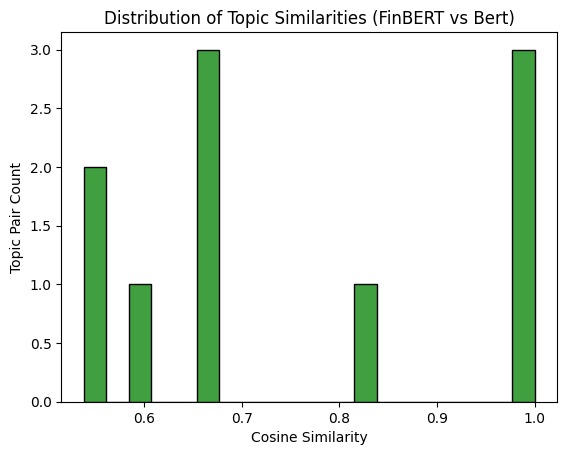

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Plot histogram of cosine similarity scores to assess overlap between FinBERT and BertMPNet topics.

similarities = [match[2] for match in matches]
sns.histplot(similarities, bins=20, color='green')
plt.title("Distribution of Topic Similarities (FinBERT vs Bert)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Topic Pair Count")
plt.show()

In [ ]:

trend_Hsbc = Hsbc_df[Hsbc_df['topic_finbert'].isin(matched_ids)]
Hsbc_trend_summary = trend_Hsbc.groupby(['year', 'quarter', 'topic_finbert']).size().reset_index(name='count')
Hsbc_trend_summary

,year,quarter,topic_finbert,count
0,2023,Q1,1,2
1,2023,Q1,14,1
2,2023,Q1,23,1
3,2023,Q1,26,1
4,2023,Q1,27,1
...,...,...,...,...
109,2025,Q2,77,1
110,2025,Q2,82,1
111,2025,Q2,90,1
112,2025,Q2,94,1


In [ ]:
# HSBC
hsbc_summary = Hsbc_df.groupby(['year', 'quarter', 'topic_finbert']).size().reset_index(name='count')
hsbc_summary['bank'] = 'HSBC'

# JPMorgan
jpm_summary = df_filtered.groupby(['year', 'quarter', 'topic_finbert']).size().reset_index(name='count')
jpm_summary['bank'] = 'JPMorgan'

# Combine
combined_summary = pd.concat([hsbc_summary, jpm_summary])


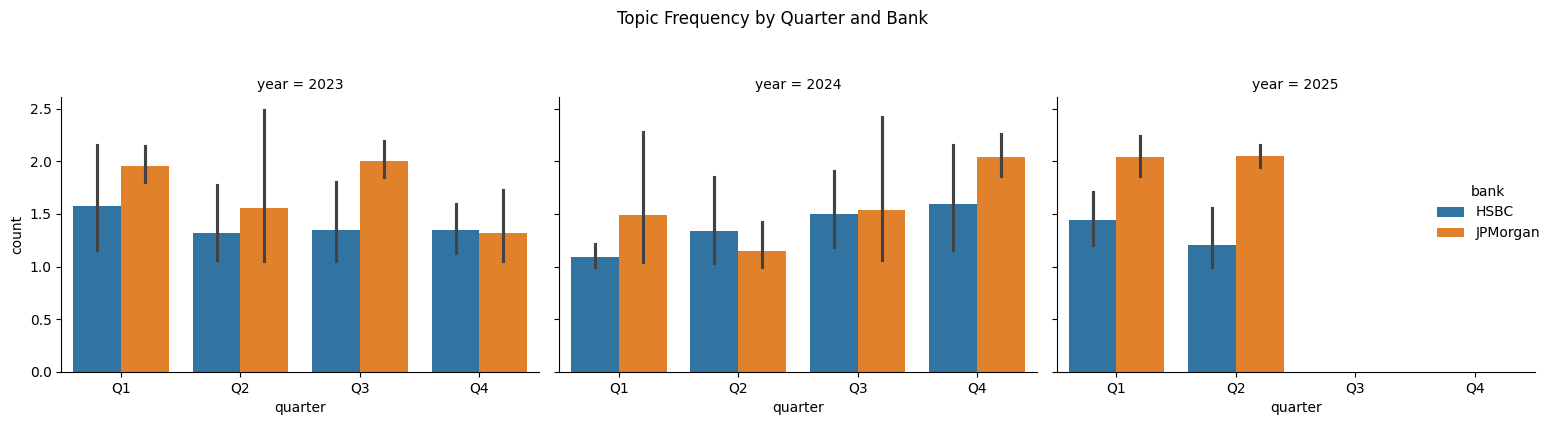

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=combined_summary, x='quarter', y='count', hue='bank', col='year', kind='bar', height=4, aspect=1.2)
plt.suptitle("Topic Frequency by Quarter and Bank", y=1.05)
plt.tight_layout()
plt.show()


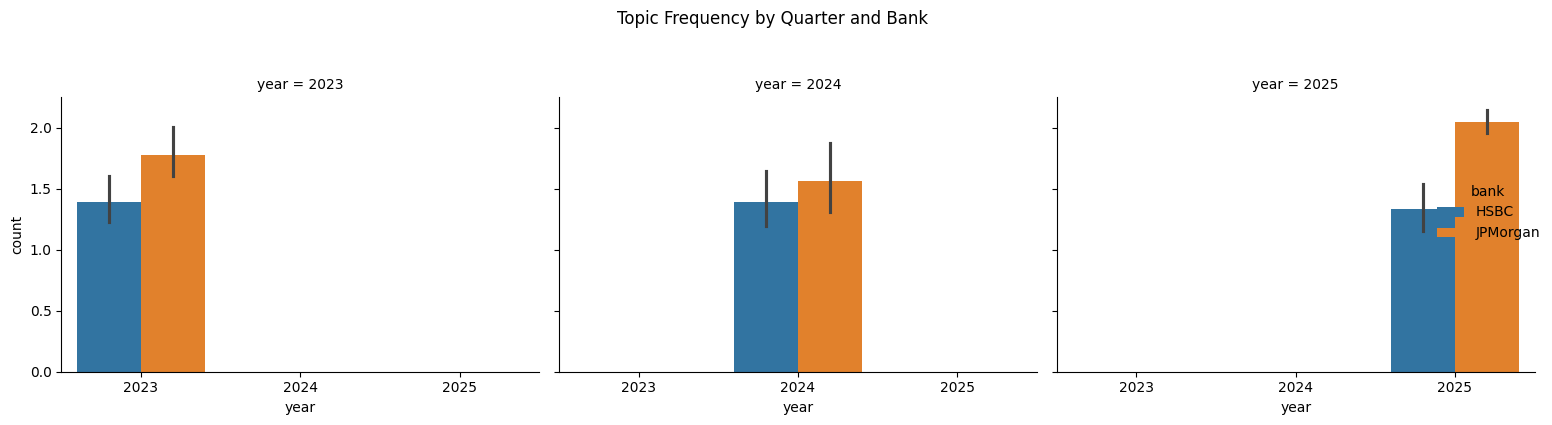

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=combined_summary, x='year', y='count', hue='bank', col='year', kind='bar', height=4, aspect=1.2)
plt.suptitle("Topic Frequency by Quarter and Bank", y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
matched_ids = [match[0] for match in matches if match[2] >= 0.82]

hsbc_matched = Hsbc_df[Hsbc_df['topic_finbert'].isin(matched_ids)].copy()
jpm_matched = df_filtered[df_filtered['topic_finbert'].isin(matched_ids)].copy()

In [ ]:
hsbc_summary = hsbc_matched.groupby(['topic_finbert', 'year', 'quarter']).size().reset_index(name='hsbc_count')
jpm_summary = jpm_matched.groupby(['topic_finbert', 'year', 'quarter']).size().reset_index(name='jpm_count')

In [ ]:
comparison_df = pd.merge(hsbc_summary, jpm_summary, on=['topic_finbert', 'year', 'quarter'], how='outer').fillna(0)

# Add difference and ratio columns
comparison_df['count_diff'] = comparison_df['hsbc_count'] - comparison_df['jpm_count']
comparison_df['count_ratio'] = comparison_df['hsbc_count'] / (comparison_df['jpm_count'] + 1e-5)

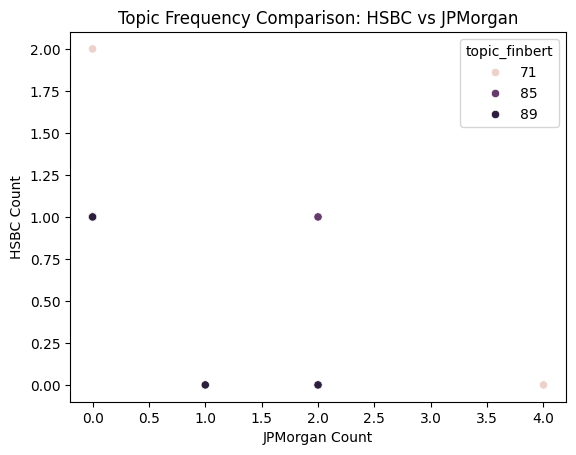

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=comparison_df, x='jpm_count', y='hsbc_count', hue='topic_finbert')
plt.title("Topic Frequency Comparison: HSBC vs JPMorgan")
plt.xlabel("JPMorgan Count")
plt.ylabel("HSBC Count")
plt.show()

In [ ]:
trend_summary = combined_summary.groupby(['year', 'quarter', 'topic_finbert', 'bank']).sum().reset_index()


In [ ]:
comparison_df['divergence'] = abs(comparison_df['hsbc_count'] - comparison_df['jpm_count'])


In [ ]:
Hsbc_df[Hsbc_df['topic_finbert'] == 1]['content'].head(3)

,content
13,I’ll deal with the second one later. I’ll as ...
23,Okay. Thank you. I’ll take the second in a m...
144,NEIL SANKOFF: We have time f or one last quest...


In [ ]:
for match in matches:
    hsbc_id, jpm_id, similarity_score = match
    print(hsbc_id, jpm_id, similarity_score)


1 0 0.8181818181818182
15 10 0.6666666666666666
35 66 0.6666666666666666
65 100 0.5384615384615384
67 44 0.6
71 74 1.0
82 88 0.5384615384615384
85 83 1.0
89 81 1.0
92 93 0.6666666666666666


In [ ]:
match_df = pd.DataFrame(matches, columns=['hsbc_topic', 'jpm_topic', 'similarity'])
match_df = match_df[match_df['similarity'] > 0.80]
match_df.head()


,hsbc_topic,jpm_topic,similarity
0,1,0,0.818182
5,71,74,1.000000
7,85,83,1.000000
8,89,81,1.000000


In [ ]:
finbert_model.get_topic(81)


[('reconciliation', 0.15811497416264172),
 ('andy', 0.12315201051473885),
 ('finish', 0.118297353462347),
 ('slide', 0.11401408776206047),
 ('revise', 0.10149371393656018),
 ('explain', 0.10149371393656018),
 ('specific', 0.09083099658403192),
 ('reiterate', 0.08746944618236813),
 ('fact', 0.08049256247817893),
 ('capture', 0.07813148616114791)]

In [ ]:
Hsbc_Fin_model.get_topic(89)

[('nasty', 0.04984810235715539),
 ('surprise', 0.04672593745289951),
 ('recruit', 0.04672593745289951),
 ('team', 0.04497502321406387),
 ('buy', 0.04023326703527648),
 ('past', 0.03823298344369774),
 ('acquisition', 0.03823298344369774),
 ('manual', 0.03617629744513861),
 ('diligence', 0.03617629744513861),
 ('quality', 0.03598001857125109)]

In [ ]:
df_filtered['bank'] = 'JPMorgan'
Hsbc_df['bank'] = 'HSBC'

combined_df = pd.concat([df_filtered, Hsbc_df], ignore_index=True)


In [ ]:
print(combined_df.columns.tolist())


['section', 'question_number', 'answer_number', 'speaker_name', 'role', 'company', 'content', 'year', 'quarter', 'is_pleasantry', 'source_pdf', 'regex_cleaned', 'spacy_tokens', 'filtered_tokens', 'filtered_string', 'token_count', 'topic', 'topic_prob', 'topic_finbert', 'topic_finbert_prob', 'bank']


In [ ]:
def truncate_text(text, max_words=250):
    return ' '.join(text.split()[:max_words])


In [ ]:
combined_df['content_trunc'] = combined_df['content'].apply(truncate_text)


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

def get_sentiment_score(text):
    result = sentiment_pipeline(text)[0]
    label = result['label']
    score = result['score']
    return score if label == 'Positive' else -score if label == 'Negative' else 0

combined_df['sentiment_score'] = combined_df['content_trunc'].apply(get_sentiment_score)

Device set to use cpu


In [ ]:
def get_sentiment_score(text):
    result = sentiment_pipeline(text)[0]
    label = result['label']
    score = result['score']
    if label == 'Positive':
        return score
    elif label == 'Negative':
        return -score
    else:
        return score * 0.1  # Give neutral a small weight

In [ ]:
df_sentiment = combined_df.groupby(['bank', 'topic_finbert'])['sentiment_score'].mean().reset_index()


In [ ]:
sentiment_trend = combined_df.groupby(['bank', 'year', 'quarter'])['sentiment_score'].mean().reset_index()


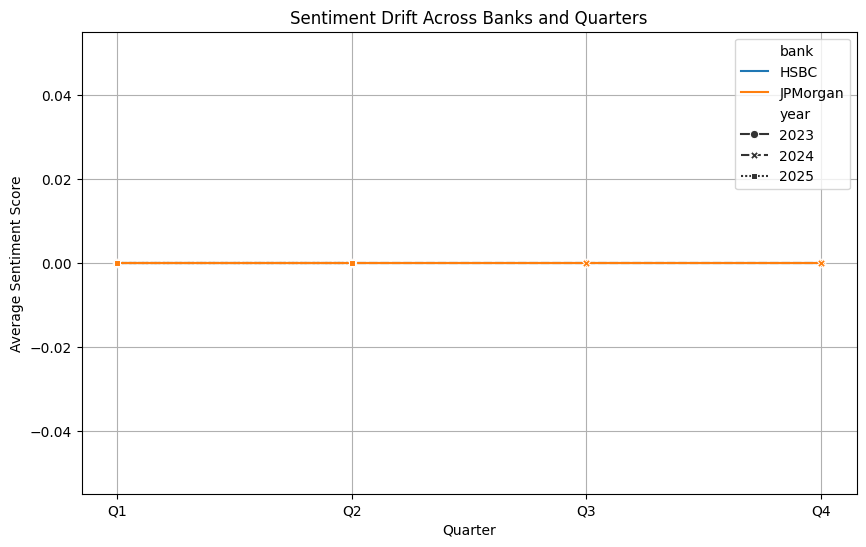

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=sentiment_trend, x='quarter', y='sentiment_score', hue='bank', style='year', markers=True)
plt.title("Sentiment Drift Across Banks and Quarters")
plt.ylabel("Average Sentiment Score")
plt.xlabel("Quarter")
plt.grid(True)
plt.show()


In [ ]:
topic_sentiment = combined_df.groupby(['bank', 'topic_finbert', 'year', 'quarter'])['sentiment_score'].mean().reset_index()


In [ ]:
speaker_sentiment = combined_df.groupby(['bank', 'speaker_name'])['sentiment_score'].mean().reset_index()


In [ ]:
def extract_label(text):
    result = sentiment_pipeline(text)[0]
    return result['label']


In [ ]:
combined_df['sentiment_label'] = combined_df['content_trunc'].apply(extract_label)


In [ ]:
combined_df['sentiment_label'].value_counts()


,count
sentiment_label,
neutral,1288
positive,194
negative,112


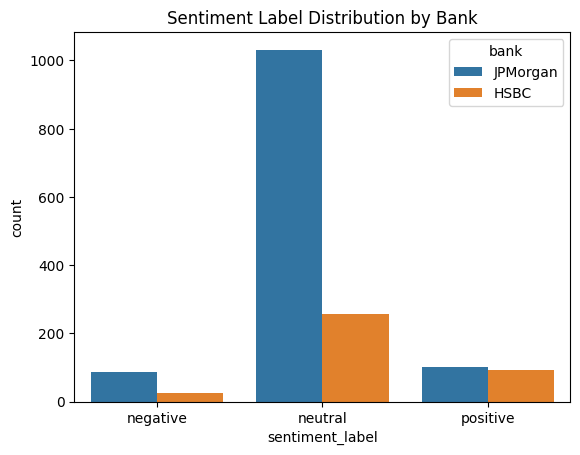

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=combined_df, x='sentiment_label', hue='bank')
plt.title("Sentiment Label Distribution by Bank")
plt.show()


In [ ]:
# Step 1: Count sentiment labels per bank
sentiment_counts = combined_df.groupby(['bank', 'sentiment_label']).size().reset_index(name='count')

# Step 2: Calculate percentage within each bank
sentiment_pct = sentiment_counts.copy()
sentiment_pct['percentage'] = sentiment_pct.groupby('bank')['count'].transform(lambda x: 100 * x / x.sum())



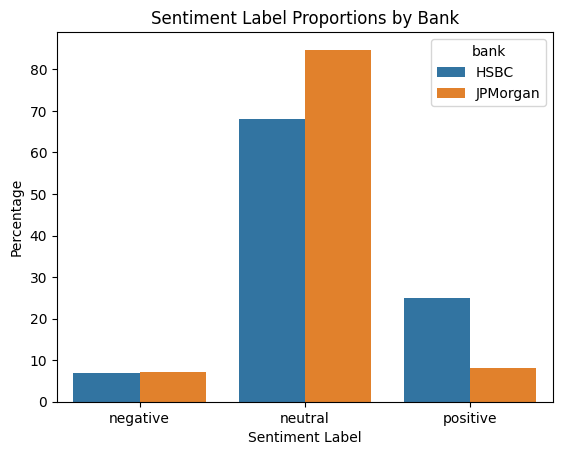

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=sentiment_pct, x='sentiment_label', y='percentage', hue='bank')
plt.title("Sentiment Label Proportions by Bank")
plt.ylabel("Percentage")
plt.xlabel("Sentiment Label")
plt.show()

In [ ]:
topic_counts = (
    combined_df.groupby(['bank', 'topic_finbert', 'sentiment_label'])
    .size()
    .reset_index(name='count')
)


In [ ]:
topic_pct = topic_counts.copy()
topic_pct['percentage'] = topic_pct.groupby(['bank', 'topic_finbert'])['count'].transform(lambda x: 100 * x / x.sum())


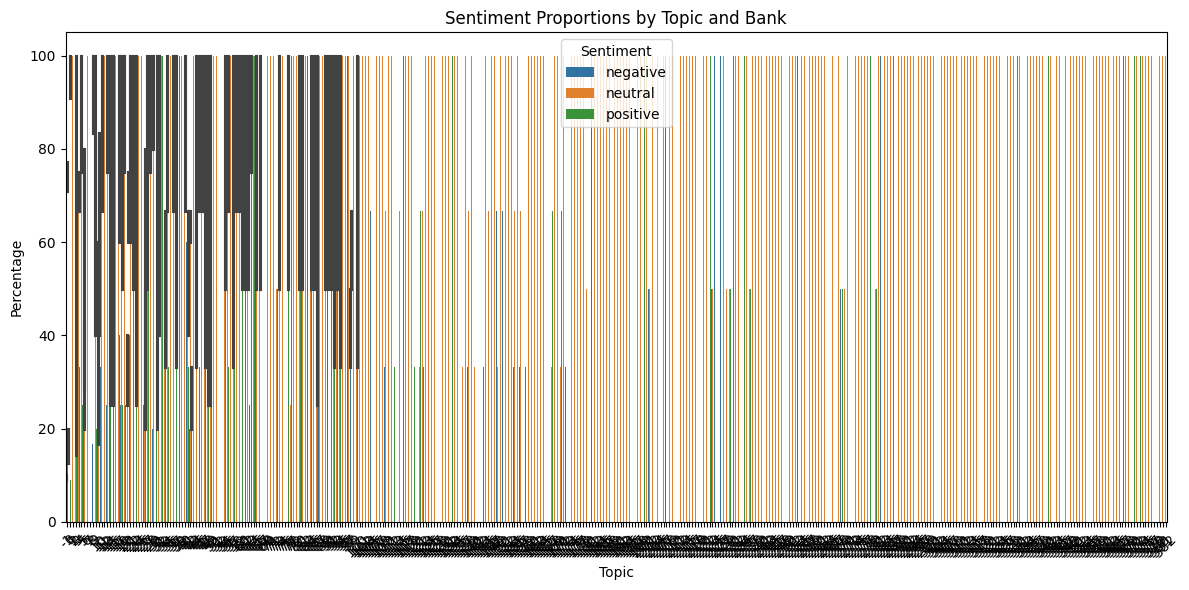

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=topic_pct, x='topic_finbert', y='percentage', hue='sentiment_label')
plt.title("Sentiment Proportions by Topic and Bank")
plt.xticks(rotation=45)
plt.ylabel("Percentage")
plt.xlabel("Topic")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


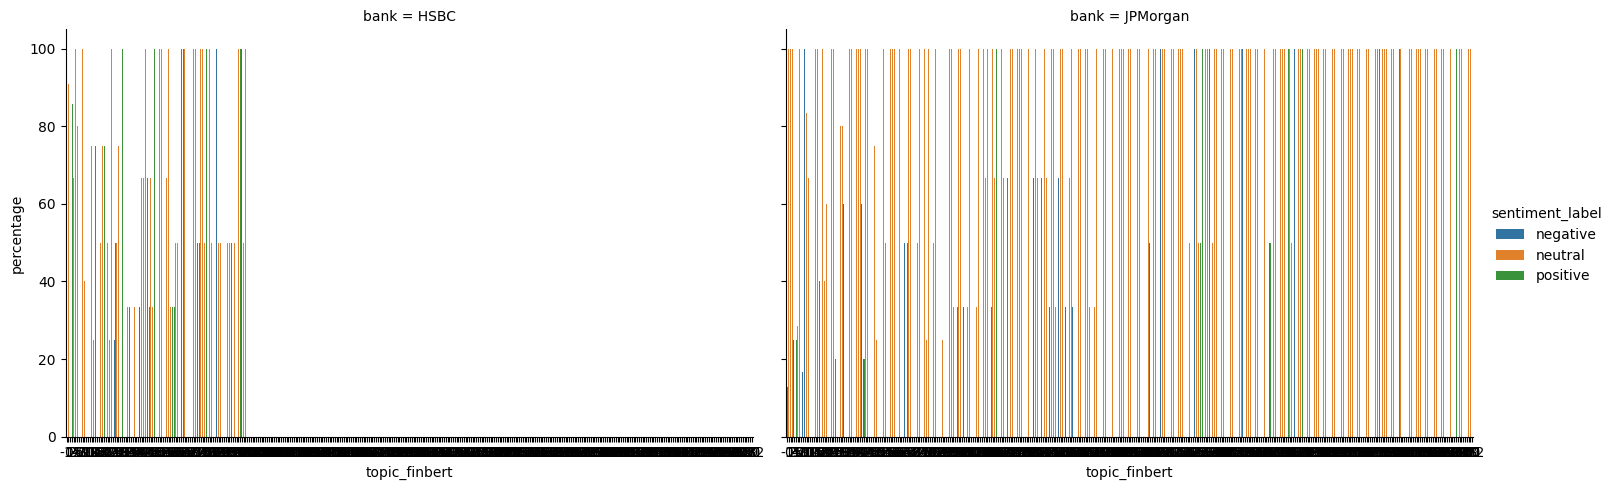

In [ ]:
sns.catplot(data=topic_pct, x='topic_finbert', y='percentage', hue='sentiment_label', col='bank', kind='bar', height=5, aspect=1.5)


In [ ]:
high_emotion = topic_pct[topic_pct['sentiment_label'] != 'Neutral']
high_emotion


,bank,topic_finbert,sentiment_label,count,percentage
0,HSBC,-1,negative,5,9.090909
1,HSBC,-1,neutral,39,70.909091
2,HSBC,-1,positive,11,20.000000
3,HSBC,0,neutral,10,90.909091
4,HSBC,0,positive,1,9.090909
...,...,...,...,...,...
599,JPMorgan,378,neutral,2,100.000000
600,JPMorgan,379,neutral,2,100.000000
601,JPMorgan,380,neutral,2,100.000000
602,JPMorgan,381,neutral,2,100.000000
